# Build a training dataset for ML-based $\Delta$FAC from multiple SNOWPACK simulations
The training dataset needs columns of the following (where each row represents one example):
1. 91 day $\Delta$FAC (m)
2. 1980 - 2021 temperature climatology (C)
3. 91 day average temperature (C)
4. 1980 - 2021 precipitation climatology (mm/hr)
5. 91 day average precipitation (mm/hr)
6. 91 - 180 day average precipitation (mm/hr)
7. 180 - 365 day average precipitation (mm/hr)
8. 365 - 730 day average precipitation (mm/hr)
9. Date sine
10. Date cosine

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import glob
from joblib import Parallel, delayed, memory

# First, get a list of SNOWPACK sites that have completed their simulation

In [8]:
%%bash
cd /scratch/summit/erke2265/mass-balance/400_sites/output/
ls -- *.sno | wc -l
basename -s .sno -- *.sno > /scratch/summit/erke2265/mass-balance/notebooks/finished.txt

328


# Next, load an array of strings composed of the finished sites

In [3]:
sites = np.loadtxt("finished.txt", dtype=str)
sites = sites[sites != '-73.000_68.750_SPINUP'] # Add hock removal of one bad site
print(len(sites))
sites

12


array(['-66.000_101.875_SPINUP', '-66.000_-61.875_SPINUP',
       '-66.500_125.625_SPINUP', '-66.500_51.250_SPINUP',
       '-66.500_53.125_SPINUP', '-67.000_106.250_SPINUP',
       '-67.500_102.500_SPINUP', '-67.500_141.875_SPINUP',
       '-67.500_-61.875_SPINUP', '-67.500_86.250_SPINUP',
       '-68.000_111.875_SPINUP', '-68.000_139.375_SPINUP'], dtype='<U23')

# Utility functions

In [4]:
def read_smet(path, var):

    """ Reads a .smet file and returns a time series of the defined variable as a pandas data frame.
    Args:
        path (str): String pointing to the location of the .smet file to be read.
        var  (str): Variable you want to plot
    Returns:
        Time series of defined variable as a pandas data frame.
    """

    # Load .smet file as a Pandas data frame
    df = pd.read_csv(path)
    
    # Get lat, lon, ratio
    lat_row = np.where(df[df.columns[0]].str.startswith("latitude"))[0][0]
    lon_row = np.where(df[df.columns[0]].str.startswith("longitude"))[0][0]
    ratio_row = np.where(df[df.columns[0]].str.startswith("units_multiplier"))[0][0]
    
    lat = float(df['SMET 1.1 ASCII'][lat_row].split()[-1])
    lon = float(df['SMET 1.1 ASCII'][lon_row].split()[-1])
    ratio = float(df['SMET 1.1 ASCII'][ratio_row].split()[-2])
    if np.isnan(ratio):
        ratio = 1

    # Determine indices for data retrieval
    bump = 2

    fields_row = np.where(df[df.columns[0]].str.startswith("fields"))[0][0] + bump
    data_row = np.where(df[df.columns[0]] == '[DATA]')[0][0] + bump
    fields =  np.loadtxt(path, skiprows=fields_row - 1, max_rows=1, dtype='str')
    data_col = []
    for k in range(0, len(var)):
        for j in range(0, len(list(fields[2:]))):
            if var[k] == fields[2+j]:
                data_col.append(j)

    # Creates pandas data frame
    time = np.loadtxt(path, skiprows=data_row, usecols=0, dtype = 'str')
    time = pd.to_datetime(time, format='%Y-%m-%dT%H:%M:%S')
    data = np.loadtxt(path, skiprows=data_row, usecols=tuple(data_col))
    df = pd.DataFrame(data, index=time)

    # Set no data values to nan
    df[df == -999] = np.nan

    # Return time series as daily average Pandas data frame
    return df, lat, lon, ratio

def calc_FAC(HS, SWE):
    
    """
    SNOWPACK assumes the density of ice is 917 kg/m^3
    """
    
    SWE_in_units_ice_equivalent = SWE / 0.917
    FAC = HS - SWE_in_units_ice_equivalent
    return FAC

def special_rolling_mean(df, n_min, n_max):
    special_mean = ((n_max * df.rolling(n_max).mean()) - (n_min * df.rolling(n_min).mean())) / (n_max - n_min)
    return special_mean

def calc_training_data(site):
    
    # File paths
    meteo_smet = "/scratch/summit/erke2265/mass-balance/400_sites/smet/" + site[:-7]+ ".smet"
    snowpack_smet = "/scratch/summit/erke2265/mass-balance/400_sites/output/" + site[:]+ ".smet"
    
    # Meteo data
    meteo_df, lat, lon, ratio = read_smet(meteo_smet, ["TA", "PSUM"])
    snowpack_df, lat, lon, ratio = read_smet(snowpack_smet, ["HS_mod", "SWE"])
    
    # Temperature
    ta = meteo_df[0].resample('D').mean()
    ta_mean = ta.mean() # Use in traning
    ta_91_day_mean = ta.rolling(91).mean() # Use in traning

    # Precip
    psum = meteo_df[1].resample('D').mean()
    psum_mean = psum.mean() # Use in traning
    psum_91_day_mean = psum.rolling(91).mean() # Use in traning
    psum_180_day_mean = special_rolling_mean(psum, 91, 180) # Use in traning
    psum_365_day_mean = special_rolling_mean(psum, 180, 365) # Use in traning
    psum_730_day_mean = special_rolling_mean(psum, 365, 730) # Use in traning
    
    # Change in FAC
    HS = snowpack_df[0] / 100 # Units: m
    SWE = snowpack_df[1] / 1000 # Units: m

    HS = HS.resample('D').mean()
    SWE = SWE.resample('D').mean()

    FAC = calc_FAC(HS, SWE)
    delta_FAC_91_day = FAC.diff(periods=91) # Use in traning
    
    # Return data
    return ta_mean, ta_91_day_mean, psum_mean, psum_91_day_mean, psum_180_day_mean, psum_365_day_mean, psum_730_day_mean, delta_FAC_91_day, lat, lon, ratio

def save_site(site, index):
    
    # Initialize training array
    train = np.array([])
    
    # Sampling index (hacky... sorry)
    ind_1980 = 729 # 2 year
    
    # Get data
    ta_mean, ta_91_day_mean, psum_mean, psum_91_day_mean, psum_180_day_mean, psum_365_day_mean, psum_730_day_mean, delta_FAC_91_day, lat, lon, ratio = calc_training_data(site)
    
    # Get sin and cos of day of year (cyclic feature)
    doy = np.zeros(len(ta_91_day_mean.index)); doy[:] = np.nan # day of year
    for k in range(0, len(ta_91_day_mean.index)):
        doy[k] = ta_91_day_mean.index[k].timetuple().tm_yday
    day_sin = np.sin(doy*(2.*np.pi/365))
    day_cos = np.cos(doy*(2.*np.pi/365))
    
    # Target data
    Y = np.squeeze(delta_FAC_91_day[ind_1980:].values)

    # Features
    RF_SMB_perturbation = np.repeat(ratio, len(Y))
    x1 = np.repeat(ta_mean, len(Y))
    x2 = np.squeeze(ta_91_day_mean[ind_1980:].values)
    x3 = np.repeat(psum_mean, len(Y)) * RF_SMB_perturbation
    x4 = np.squeeze(psum_91_day_mean[ind_1980:].values) * RF_SMB_perturbation
    x5 = np.squeeze(psum_180_day_mean[ind_1980:].values) * RF_SMB_perturbation
    x6 = np.squeeze(psum_365_day_mean[ind_1980:].values) * RF_SMB_perturbation
    x7 = np.squeeze(psum_730_day_mean[ind_1980:].values) * RF_SMB_perturbation
    x8 = day_sin[ind_1980:]
    x9 = day_cos[ind_1980:]
    
    # Combine features into readibly savable format
    lat_lon = np.array([[lat, lon]])
    train = np.transpose(np.stack([Y, x1, x2, x3, x4, x5, x6, x7, x8, x9]))
    
    # Save array
    np.save("training_data/" + str(index) + "_train.npy", train)
    np.save("training_data/" + str(index) + "_lat_lon.npy", lat_lon)

# Loop over each site and save array of training data and lat/lon

In [5]:
!rm training_data/*
Parallel(n_jobs=12)(delayed(save_site)(sites[j], j) for j in range(0, len(sites)))

[None, None, None, None, None, None, None, None, None, None, None, None]

# Make map

In [6]:
filenames = glob.glob("training_data/*lat_lon.npy")
lat_lon = np.array([np.load(fname) for fname in filenames])
lat_lon = lat_lon.reshape(lat_lon.shape[1]*lat_lon.shape[0], lat_lon.shape[2])

/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


(12, 2)


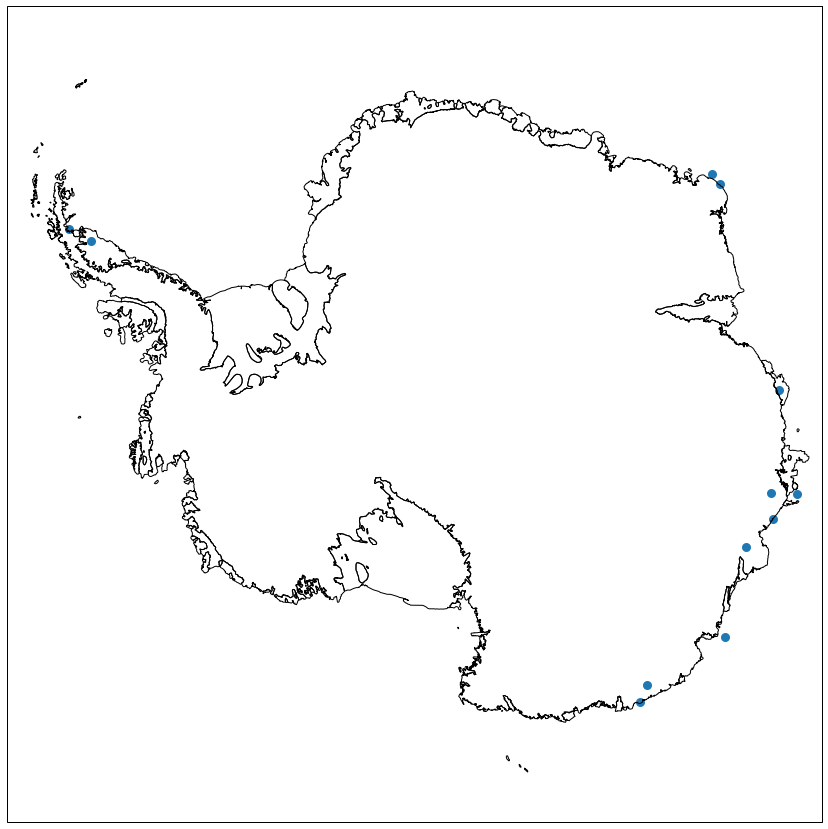

In [7]:
# Get coastlines
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(15, 15))

# Plot sites
plt.scatter(lat_lon[:,1], lat_lon[:,0], linewidth=3, transform=ccrs.PlateCarree())


# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')
print(lat_lon.shape)